In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error, root_mean_squared_error
color_pal = sns.color_palette()
sns.set()

In [2]:
df = pd.read_csv('./march_hourly.csv', delimiter=";")
df = df.set_index('Start date')
df.index = pd.to_datetime(df.index)

df.rename(columns={"Germany/Luxembourg [€/MWh] Original resolutions": "Price"}, inplace=True)
df

<ipython-input-2-6d8c505ea55e>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


,End date,Price
Start date,,
2024-03-17 00:00:00,"Mar 17, 2024 1:00 AM",64.99
2024-03-17 01:00:00,"Mar 17, 2024 2:00 AM",60.49
2024-03-17 02:00:00,"Mar 17, 2024 3:00 AM",55.97
2024-03-17 03:00:00,"Mar 17, 2024 4:00 AM",58.75
2024-03-17 04:00:00,"Mar 17, 2024 5:00 AM",60.45
...,...,...
2024-03-30 19:00:00,"Mar 30, 2024 8:00 PM",83.53
2024-03-30 20:00:00,"Mar 30, 2024 9:00 PM",74.11
2024-03-30 21:00:00,"Mar 30, 2024 10:00 PM",71.47


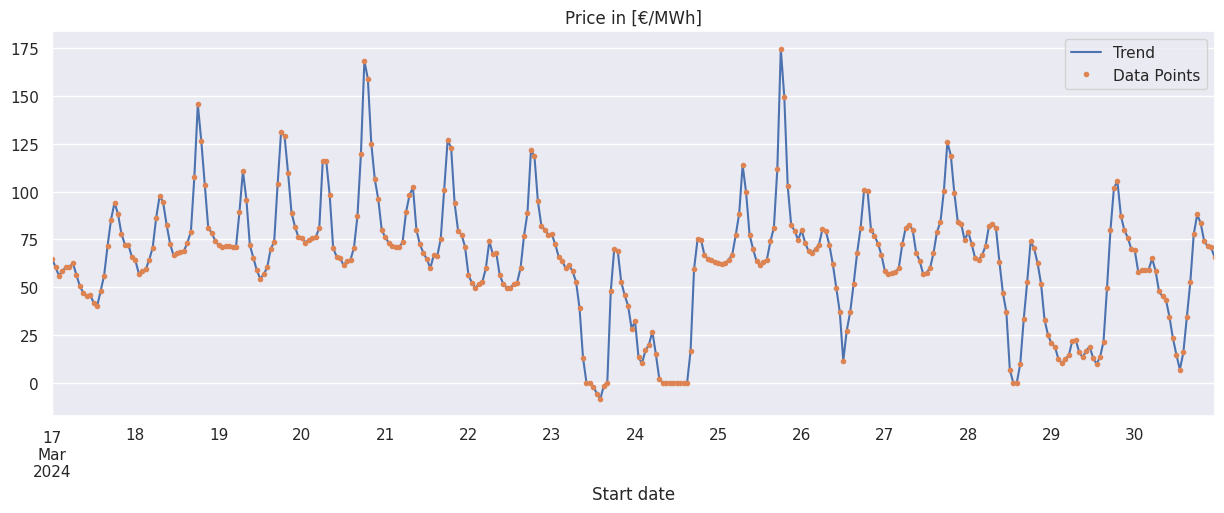

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data trend (line)
df.plot(style='-', ax=ax, label='Trend', title='Price in [€/MWh]')

# Plot the actual data points (dots)
df.plot(style='.', ax=ax, label='Data Points')

ax.legend(['Trend', 'Data Points'])

# Show the plot
plt.show()

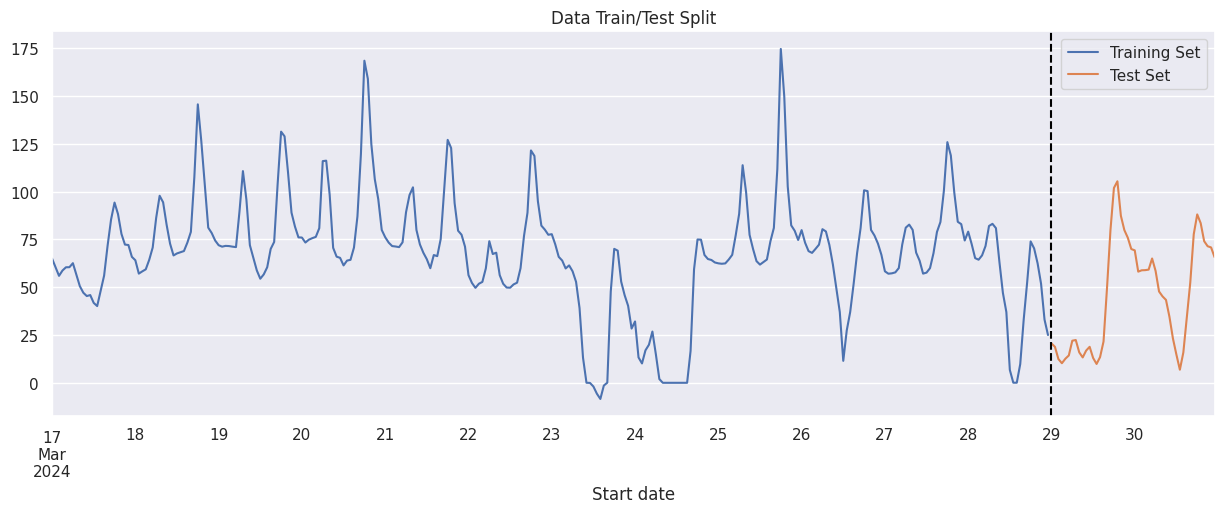

In [4]:
SPLIT_DATE = '29-03-2024'
train = df.loc[df.index < SPLIT_DATE]
test = df.loc[df.index >= SPLIT_DATE]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(SPLIT_DATE, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [5]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df

,End date,Price,hour,dayofweek,dayofyear,weekofyear
Start date,,,,,,
2024-03-17 00:00:00,"Mar 17, 2024 1:00 AM",64.99,0,6,77,11
2024-03-17 01:00:00,"Mar 17, 2024 2:00 AM",60.49,1,6,77,11
2024-03-17 02:00:00,"Mar 17, 2024 3:00 AM",55.97,2,6,77,11
2024-03-17 03:00:00,"Mar 17, 2024 4:00 AM",58.75,3,6,77,11
2024-03-17 04:00:00,"Mar 17, 2024 5:00 AM",60.45,4,6,77,11
...,...,...,...,...,...,...
2024-03-30 19:00:00,"Mar 30, 2024 8:00 PM",83.53,19,5,90,13
2024-03-30 20:00:00,"Mar 30, 2024 9:00 PM",74.11,20,5,90,13
2024-03-30 21:00:00,"Mar 30, 2024 10:00 PM",71.47,21,5,90,13


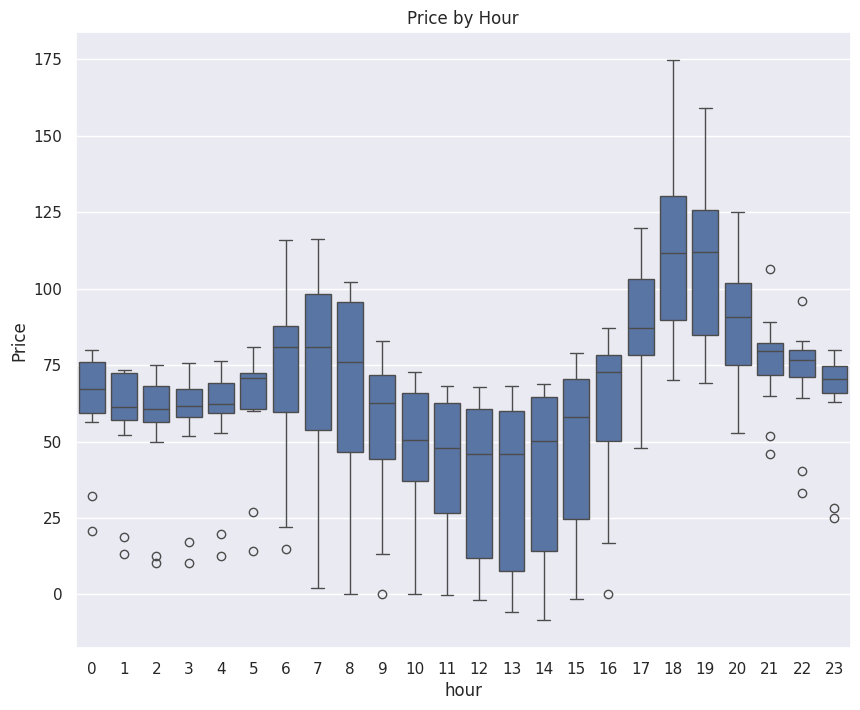

In [6]:
TARGET = 'Price'

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y=TARGET)
ax.set_title('Price by Hour')
plt.show()

In [7]:
# process Train and Test Splits
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofyear', 'dayofweek']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [8]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=25)

[0]	validation_0-rmse:72.69784	validation_1-rmse:52.90988
[100]	validation_0-rmse:31.48947	validation_1-rmse:34.05339
[200]	validation_0-rmse:17.20606	validation_1-rmse:29.22036
[300]	validation_0-rmse:12.43413	validation_1-rmse:28.11362
[353]	validation_0-rmse:11.20481	validation_1-rmse:28.35648


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:29:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

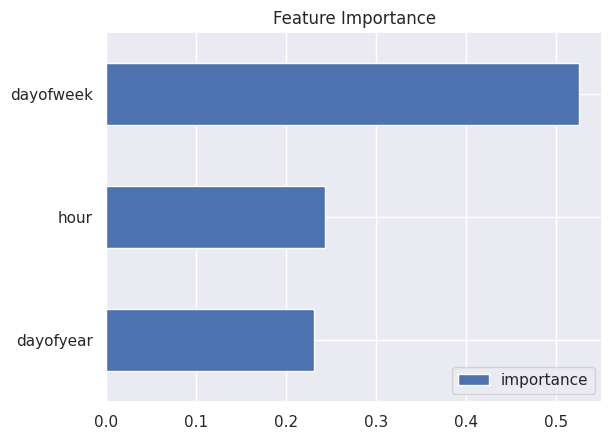

In [9]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [10]:
test['prediction'] = reg.predict(X_test)
test

,End date,Price,hour,dayofweek,dayofyear,weekofyear,prediction
Start date,,,,,,,
2024-03-29 00:00:00,"Mar 29, 2024 1:00 AM",20.60,0,4,89,13,57.368252
2024-03-29 01:00:00,"Mar 29, 2024 2:00 AM",18.83,1,4,89,13,57.368252
2024-03-29 02:00:00,"Mar 29, 2024 3:00 AM",12.43,2,4,89,13,57.368252
2024-03-29 03:00:00,"Mar 29, 2024 4:00 AM",10.24,3,4,89,13,57.368252
2024-03-29 04:00:00,"Mar 29, 2024 5:00 AM",12.59,4,4,89,13,57.368252
2024-03-29 05:00:00,"Mar 29, 2024 6:00 AM",14.32,5,4,89,13,57.368252
2024-03-29 06:00:00,"Mar 29, 2024 7:00 AM",22.02,6,4,89,13,60.386349
2024-03-29 07:00:00,"Mar 29, 2024 8:00 AM",22.39,7,4,89,13,59.782932
2024-03-29 08:00:00,"Mar 29, 2024 9:00 AM",15.94,8,4,89,13,58.351234


In [11]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

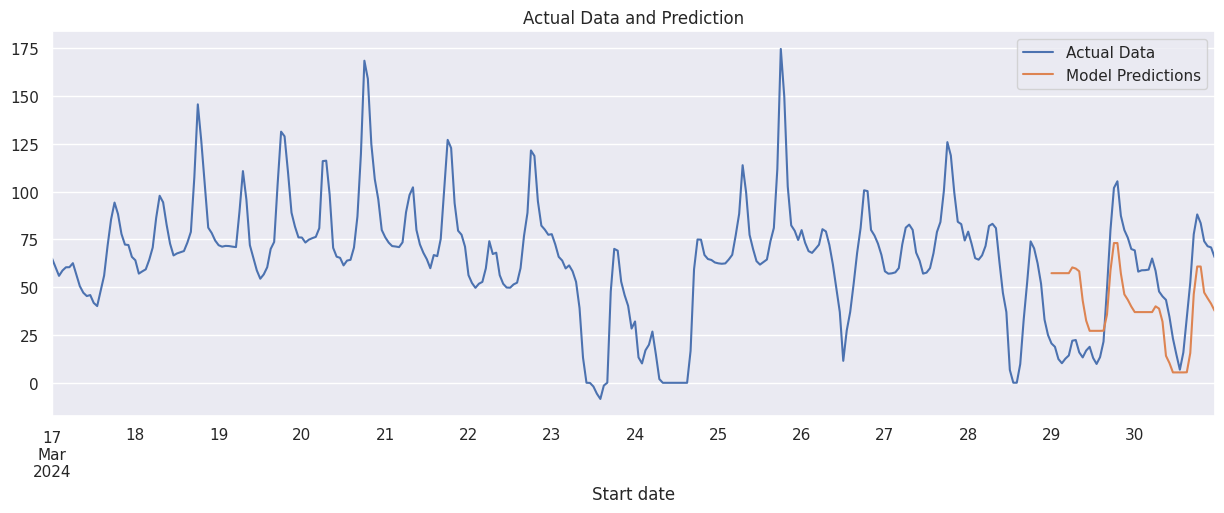

In [13]:
ax = df[[TARGET]].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-')
plt.legend(['Actual Data', 'Model Predictions'])
ax.set_title('Actual Data and Prediction')
plt.show()

In [18]:
#test error fot the entire test set
score = root_mean_squared_error(test[TARGET], test['prediction'])
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 28.09


In [21]:
#days and (absolute) error realtion
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean()

,error
date,
2024-03-29,29.191774
2024-03-30,22.464188
